# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [29]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [30]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\analysis


In [31]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [32]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [33]:
# data_hosp_rate_all = pd.read_csv(f'../output/measures/input_hospitalisation_rate_2019-01-01.csv.gz')
# data_hosp_rate_all.head()

In [34]:
# data_hosp_rate_all.columns

In [35]:
# data_hosp_rate_all.admitted_date.value_counts()

In [36]:
data_hosp_rate = pd.read_csv(f'../output/measures/measure_hosp_rate.csv')
data_hosp_rate_sex = pd.read_csv(f'../output/measures/measure_hosp_rate_sex.csv') 
data_hosp_rate_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_age_cat.csv')
data_hosp_rate_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_cat.csv')
data_hosp_rate_gp = pd.read_csv(f'../output/measures/measure_hosp_rate_gp.csv')

data_hosp_rate_sex.head()#.shape

,sex,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0,1405.0,464,3.028017,2019-01-01
1,F,1,204.0,43,4.744186,2019-01-01
2,M,0,1348.0,436,3.091743,2019-01-01
3,M,1,211.0,57,3.701754,2019-01-01
4,F,0,1583.0,473,3.346723,2019-02-01


In [37]:
data_hosp_rate = data_hosp_rate[data_hosp_rate['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_sex = data_hosp_rate_sex[data_hosp_rate_sex['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_cat = data_hosp_rate_cat[data_hosp_rate_cat['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_gp = data_hosp_rate_gp[data_hosp_rate_gp['sgss_gp_cov_admitted_binary']==0]

data_hosp_rate_sex.head()#.shape

,sex,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0,1405.0,464,3.028017,2019-01-01
2,M,0,1348.0,436,3.091743,2019-01-01
4,F,0,1583.0,473,3.346723,2019-02-01
6,M,0,1472.0,427,3.447307,2019-02-01
8,F,0,1632.0,463,3.524838,2019-03-01


In [38]:
# translate sex in data_hosp_rate_sex_age_cat
dict_sex = {'F': 'Female', 'M': 'Male'}
data_hosp_rate_sex = data_hosp_rate_sex.replace({"sex": dict_sex})

In [39]:
data_hosp_rate.describe(include='all')

,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,38.0,38.000000,38.0,38.000000,38
unique,NaN,NaN,NaN,NaN,38
top,NaN,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,NaN,1
mean,0.0,2982.236842,900.0,3.313596,NaN
std,0.0,73.563150,0.0,0.081737,NaN
min,0.0,2753.000000,900.0,3.058889,NaN
25%,0.0,2947.500000,900.0,3.275000,NaN
50%,0.0,2983.000000,900.0,3.314444,NaN
75%,0.0,3026.250000,900.0,3.362500,NaN


In [40]:
data_hosp_rate_sex.describe(include='all')

,sex,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,76,76.0,76.000000,76.000000,76.000000,76
unique,2,NaN,NaN,NaN,NaN,38
top,Female,NaN,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,NaN,2
mean,NaN,0.0,1491.118421,450.000000,3.313696,NaN
std,NaN,0.0,76.438030,15.864426,0.125878,NaN
min,NaN,0.0,1316.000000,422.000000,3.028017,NaN
25%,NaN,0.0,1437.500000,437.000000,3.225273,NaN
50%,NaN,0.0,1487.500000,450.000000,3.315088,NaN
75%,NaN,0.0,1545.250000,463.000000,3.404341,NaN


In [41]:
data_hosp_rate_age_cat.describe(include='all')

,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,190,190.0,190.000000,190.000000,190.000000,190
unique,5,NaN,NaN,NaN,NaN,38
top,0-14,NaN,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,NaN,5
mean,NaN,0.0,596.447368,180.000000,3.316191,NaN
std,NaN,0.0,130.901736,37.187641,0.267620,NaN
min,NaN,0.0,279.000000,80.000000,2.596859,NaN
25%,NaN,0.0,553.750000,180.250000,3.133964,NaN
50%,NaN,0.0,643.000000,194.000000,3.316194,NaN
75%,NaN,0.0,680.250000,203.000000,3.494435,NaN


In [42]:
data_hosp_rate_cat.describe(include='all')

,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,418,456.0,456.000000,456.00000,456.000000,456
unique,11,NaN,NaN,NaN,NaN,38
top,A39,NaN,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,NaN,12
mean,NaN,0.0,248.519737,75.00000,3.312071,NaN
std,NaN,0.0,555.782584,167.38443,0.729101,NaN
min,NaN,0.0,9.000000,7.00000,1.000000,NaN
25%,NaN,0.0,65.000000,21.00000,2.845553,NaN
50%,NaN,0.0,86.000000,26.00000,3.292992,NaN
75%,NaN,0.0,108.000000,31.00000,3.707983,NaN


In [43]:
data_hosp_rate_gp.describe(include='all')

,gp_cons_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,76.000000,76.0,76.000000,76.000000,76.000000,76
unique,NaN,NaN,NaN,NaN,NaN,38
top,NaN,NaN,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,NaN,NaN,2
mean,0.500000,0.0,1491.118421,450.000000,3.313506,NaN
std,0.503322,0.0,61.962777,5.537749,0.129236,NaN
min,0.000000,0.0,1332.000000,438.000000,2.966592,NaN
25%,0.000000,0.0,1437.750000,446.000000,3.233416,NaN
50%,0.500000,0.0,1496.500000,450.000000,3.314383,NaN
75%,1.000000,0.0,1529.250000,454.000000,3.393055,NaN


## 2- Hospital admission rate

In [44]:
data_hosp_rate

,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,0,2753.0,900,3.058889,2019-01-01
2,0,3055.0,900,3.394444,2019-02-01
4,0,3001.0,900,3.334444,2019-03-01
6,0,3059.0,900,3.398889,2019-04-01
8,0,2969.0,900,3.298889,2019-05-01
10,0,2883.0,900,3.203333,2019-06-01
12,0,2895.0,900,3.216667,2019-07-01
14,0,2988.0,900,3.320000,2019-08-01
16,0,2972.0,900,3.302222,2019-09-01
18,0,3067.0,900,3.407778,2019-10-01


In [45]:
data_hosp_rate_groupby_date = data_hosp_rate.groupby([data_hosp_rate['date']]).mean().reset_index()
data_hosp_rate_groupby_date.head()

,date,sgss_gp_cov_admitted_binary,admitted,population,value
0,2019-01-01,0.0,2753.0,900.0,3.058889
1,2019-02-01,0.0,3055.0,900.0,3.394444
2,2019-03-01,0.0,3001.0,900.0,3.334444
3,2019-04-01,0.0,3059.0,900.0,3.398889
4,2019-05-01,0.0,2969.0,900.0,3.298889


In [46]:
# data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date.index

data_hosp_rate_groupby_date['date'] = pd.to_datetime(data_hosp_rate_groupby_date['date'])

data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date['date'].dt.strftime('%Y-%m')

# data_hosp_rate_groupby_date.index = data_hosp_rate_groupby_date.date

# data_hosp_rate_groupby_date = data_hosp_rate_groupby_date.drop(columns=['date'])

data_hosp_rate_groupby_date.head()

,date,sgss_gp_cov_admitted_binary,admitted,population,value
0,2019-01,0.0,2753.0,900.0,3.058889
1,2019-02,0.0,3055.0,900.0,3.394444
2,2019-03,0.0,3001.0,900.0,3.334444
3,2019-04,0.0,3059.0,900.0,3.398889
4,2019-05,0.0,2969.0,900.0,3.298889


In [47]:
data_hosp_rate_groupby_date['value'] = data_hosp_rate_groupby_date['value']*1000

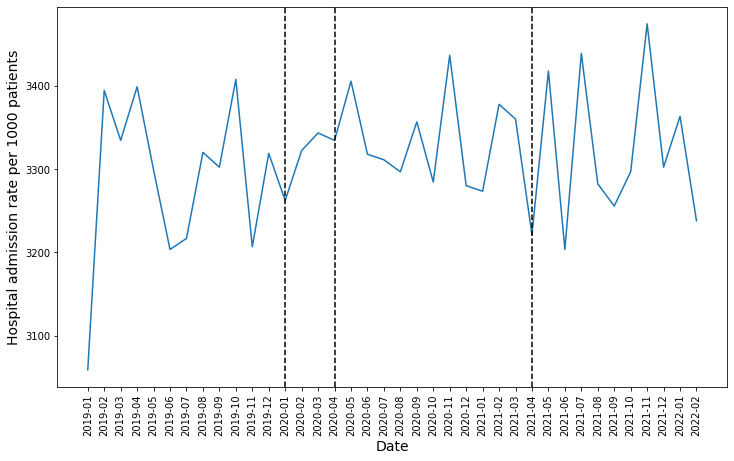

In [48]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(y=data_hosp_rate_groupby_date['value'], x=data_hosp_rate_groupby_date['date'], ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_1000_patient.jpg')
plt.show()

## 3- Hospital admission with sex

In [49]:
data_hosp_rate_sex

,sex,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,Female,0,1405.0,464,3.028017,2019-01-01
2,Male,0,1348.0,436,3.091743,2019-01-01
4,Female,0,1583.0,473,3.346723,2019-02-01
6,Male,0,1472.0,427,3.447307,2019-02-01
8,Female,0,1632.0,463,3.524838,2019-03-01
...,...,...,...,...,...,...
142,Male,0,1433.0,429,3.340326,2021-12-01
144,Female,0,1396.0,424,3.292453,2022-01-01
146,Male,0,1631.0,476,3.426471,2022-01-01
148,Female,0,1503.0,469,3.204691,2022-02-01


In [50]:
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_sex.groupby(['date', 'sex']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_cat_sex_groupby_sex.reset_index()
data_hosp_rate_cat_sex_groupby_sex.columns = ['date', 'sex', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01-01,Female,3.028017,3.028017,3.028017,3.028017
1,2019-01-01,Male,3.091743,3.091743,3.091743,3.091743
2,2019-02-01,Female,3.346723,3.346723,3.346723,3.346723
3,2019-02-01,Male,3.447307,3.447307,3.447307,3.447307
4,2019-03-01,Female,3.524838,3.524838,3.524838,3.524838


In [51]:
data_hosp_rate_cat_sex_groupby_sex.date = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex.date)

data_hosp_rate_cat_sex_groupby_sex.date = data_hosp_rate_cat_sex_groupby_sex.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01,Female,3.028017,3.028017,3.028017,3.028017
1,2019-01,Male,3.091743,3.091743,3.091743,3.091743
2,2019-02,Female,3.346723,3.346723,3.346723,3.346723
3,2019-02,Male,3.447307,3.447307,3.447307,3.447307
4,2019-03,Female,3.524838,3.524838,3.524838,3.524838


In [52]:
data_hosp_rate_cat_sex_groupby_sex['value_mean'] = data_hosp_rate_cat_sex_groupby_sex['value_mean']*1000

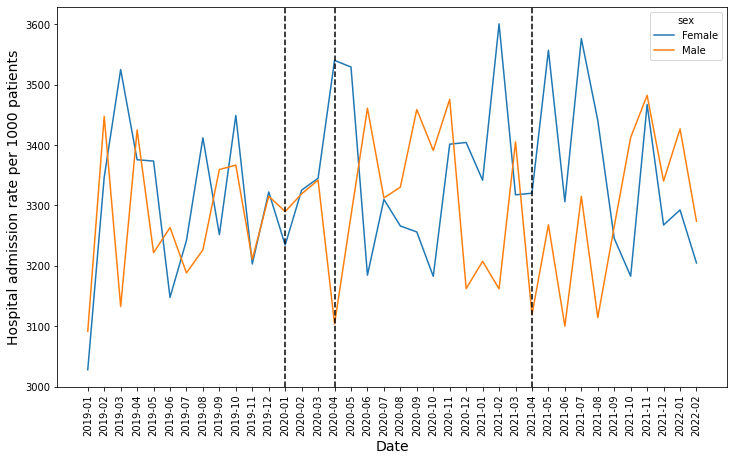

In [53]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
plt.show()

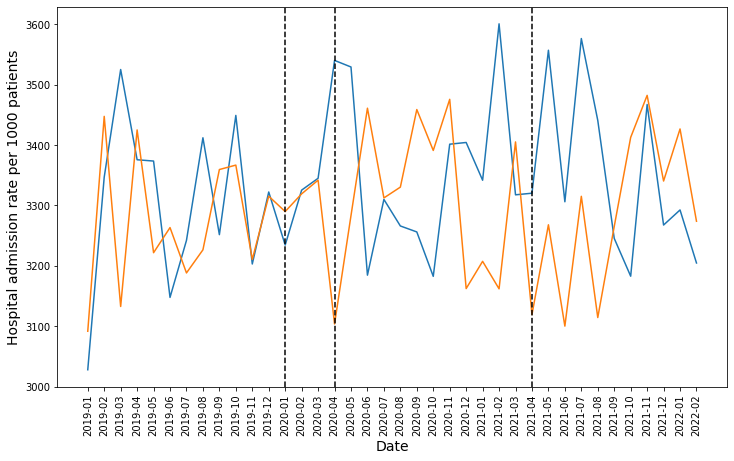

In [54]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission with age_cat

In [59]:
data_hosp_rate_age_cat

,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,0-14,0,358.0,105,3.409524,2019-01-01
2,15-34,0,471.0,179,2.631285,2019-01-01
4,35-54,0,662.0,206,3.213592,2019-01-01
6,55-74,0,640.0,197,3.248731,2019-01-01
8,75+,0,622.0,213,2.920188,2019-01-01
...,...,...,...,...,...,...
370,0-14,0,373.0,100,3.730000,2022-02-01
372,15-34,0,631.0,190,3.321053,2022-02-01
374,35-54,0,642.0,188,3.414894,2022-02-01
376,55-74,0,569.0,190,2.994737,2022-02-01


In [60]:
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != 0]
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != '0']
data_hosp_rate_age_cat

,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,0-14,0,358.0,105,3.409524,2019-01-01
2,15-34,0,471.0,179,2.631285,2019-01-01
4,35-54,0,662.0,206,3.213592,2019-01-01
6,55-74,0,640.0,197,3.248731,2019-01-01
8,75+,0,622.0,213,2.920188,2019-01-01
...,...,...,...,...,...,...
370,0-14,0,373.0,100,3.730000,2022-02-01
372,15-34,0,631.0,190,3.321053,2022-02-01
374,35-54,0,642.0,188,3.414894,2022-02-01
376,55-74,0,569.0,190,2.994737,2022-02-01


In [61]:
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_age_cat.groupby(['date', 'age_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_cat_age_cat_groupby_age.reset_index()
data_hosp_rate_cat_age_cat_groupby_age.columns = ['date', 'age', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01-01,0-14,3.409524,3.409524,3.409524,3.409524
1,2019-01-01,15-34,2.631285,2.631285,2.631285,2.631285
2,2019-01-01,35-54,3.213592,3.213592,3.213592,3.213592
3,2019-01-01,55-74,3.248731,3.248731,3.248731,3.248731
4,2019-01-01,75+,2.920188,2.920188,2.920188,2.920188


In [62]:
data_hosp_rate_cat_age_cat_groupby_age.date = pd.to_datetime(data_hosp_rate_cat_age_cat_groupby_age.date)

data_hosp_rate_cat_age_cat_groupby_age.date = data_hosp_rate_cat_age_cat_groupby_age.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01,0-14,3.409524,3.409524,3.409524,3.409524
1,2019-01,15-34,2.631285,2.631285,2.631285,2.631285
2,2019-01,35-54,3.213592,3.213592,3.213592,3.213592
3,2019-01,55-74,3.248731,3.248731,3.248731,3.248731
4,2019-01,75+,2.920188,2.920188,2.920188,2.920188


In [63]:
data_hosp_rate_cat_age_cat_groupby_age['value_mean'] = data_hosp_rate_cat_age_cat_groupby_age['value_mean']*1000

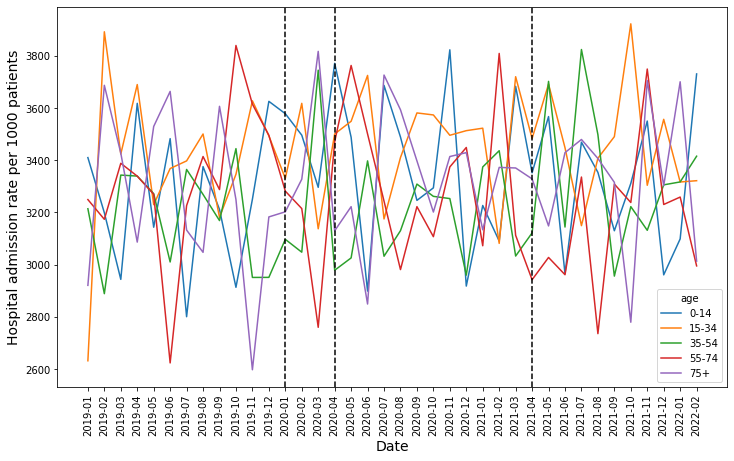

In [64]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient.jpg')
plt.show()

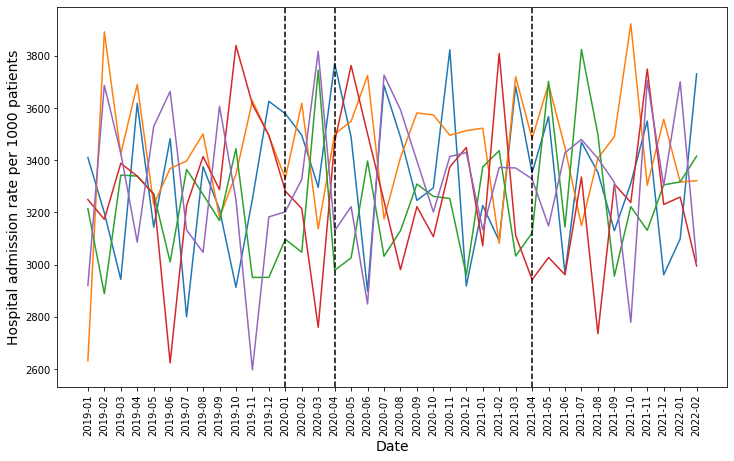

In [65]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient_nolegend.jpg')
plt.show()

## 5- Hospital admission with category

In [66]:
data_hosp_rate_cat

,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,NaN,0,1950.0,628.0,3.105096,2019-01-01
2,A39,0,106.0,33.0,3.212121,2019-01-01
4,A40,0,85.0,23.0,3.695652,2019-01-01
6,A41,0,66.0,16.0,4.125000,2019-01-01
8,B95,0,53.0,15.0,3.533333,2019-01-01
...,...,...,...,...,...,...
902,J13,0,79.0,30.0,2.633333,2022-02-01
904,K05,0,149.0,38.0,3.921053,2022-02-01
906,L01,0,85.0,30.0,2.833333,2022-02-01
908,M00,0,69.0,25.0,2.760000,2022-02-01


In [67]:
data_hosp_rate_cat.isnull().sum()

admitted_cat                   38
sgss_gp_cov_admitted_binary     0
admitted                        0
population                      0
value                           0
date                            0
dtype: int64

In [68]:
#drop rows with missing values
# data_hosp_rate_cat = data_hosp_rate_cat.dropna(axis='rows')
print(f'shape of data_hosp_rate_cat: {data_hosp_rate_cat.shape}\n')
data_hosp_rate_cat.head()

shape of data_hosp_rate_cat: (456, 6)



,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,NaN,0,1950.0,628.0,3.105096,2019-01-01
2,A39,0,106.0,33.0,3.212121,2019-01-01
4,A40,0,85.0,23.0,3.695652,2019-01-01
6,A41,0,66.0,16.0,4.125000,2019-01-01
8,B95,0,53.0,15.0,3.533333,2019-01-01


In [69]:
data_hosp_rate_cat = data_hosp_rate_cat[data_hosp_rate_cat['admitted_cat'].notna()]
data_hosp_rate_cat

,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
2,A39,0,106.0,33.0,3.212121,2019-01-01
4,A40,0,85.0,23.0,3.695652,2019-01-01
6,A41,0,66.0,16.0,4.125000,2019-01-01
8,B95,0,53.0,15.0,3.533333,2019-01-01
10,G00,0,48.0,19.0,2.526316,2019-01-01
...,...,...,...,...,...,...
902,J13,0,79.0,30.0,2.633333,2022-02-01
904,K05,0,149.0,38.0,3.921053,2022-02-01
906,L01,0,85.0,30.0,2.833333,2022-02-01
908,M00,0,69.0,25.0,2.760000,2022-02-01


In [70]:
# data_hosp_rate_cat[data_hosp_rate_cat["admitted_cat"].str.contains("A40")]
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A40'), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A41'), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N39'), 'admitted_cat'] = 'UTI-related'
data_hosp_rate_cat

,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
2,A39,0,106.0,33.0,3.212121,2019-01-01
4,Sepsis,0,85.0,23.0,3.695652,2019-01-01
6,Sepsis,0,66.0,16.0,4.125000,2019-01-01
8,B95,0,53.0,15.0,3.533333,2019-01-01
10,G00,0,48.0,19.0,2.526316,2019-01-01
...,...,...,...,...,...,...
902,J13,0,79.0,30.0,2.633333,2022-02-01
904,K05,0,149.0,38.0,3.921053,2022-02-01
906,L01,0,85.0,30.0,2.833333,2022-02-01
908,M00,0,69.0,25.0,2.760000,2022-02-01


In [71]:
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A'), 'admitted_cat'] = 'A'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('B'), 'admitted_cat'] = 'B'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('G'), 'admitted_cat'] = 'G'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('H'), 'admitted_cat'] = 'H'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('J'), 'admitted_cat'] = 'J'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('K'), 'admitted_cat'] = 'K'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('L'), 'admitted_cat'] = 'L'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('M'), 'admitted_cat'] = 'M'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N'), 'admitted_cat'] = 'N'

data_hosp_rate_cat

,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
2,A,0,106.0,33.0,3.212121,2019-01-01
4,Sepsis,0,85.0,23.0,3.695652,2019-01-01
6,Sepsis,0,66.0,16.0,4.125000,2019-01-01
8,B,0,53.0,15.0,3.533333,2019-01-01
10,G,0,48.0,19.0,2.526316,2019-01-01
...,...,...,...,...,...,...
902,J,0,79.0,30.0,2.633333,2022-02-01
904,K,0,149.0,38.0,3.921053,2022-02-01
906,L,0,85.0,30.0,2.833333,2022-02-01
908,M,0,69.0,25.0,2.760000,2022-02-01


In [72]:
data_hosp_rate_cat.admitted_cat.value_counts()

Sepsis    76
A         38
B         38
G         38
H         38
J         38
K         38
L         38
M         38
N         38
Name: admitted_cat, dtype: int64

In [25]:
# data_hosp_rate_cat.admitted_cat = data_hosp_rate_cat.admitted_cat.str.replace('[^a-zA-Z]', '')
# data_hosp_rate_cat

In [73]:
data_hosp_rate_cat_groupby_date = data_hosp_rate_cat.groupby(['date', 'admitted_cat']).agg({'value': ['mean', 'min', 'max', 'sum', 'count']})
data_hosp_rate_cat_groupby_date = data_hosp_rate_cat_groupby_date.reset_index()
data_hosp_rate_cat_groupby_date.columns = ['date', 'admitted_cat', 'value_mean', 'value_min', 'value_max', 'value_sum', 'value_count']
data_hosp_rate_cat_groupby_date

,date,admitted_cat,value_mean,value_min,value_max,value_sum,value_count
0,2019-01-01,A,3.212121,3.212121,3.212121,3.212121,1
1,2019-01-01,B,3.533333,3.533333,3.533333,3.533333,1
2,2019-01-01,G,2.526316,2.526316,2.526316,2.526316,1
3,2019-01-01,H,2.966667,2.966667,2.966667,2.966667,1
4,2019-01-01,J,3.000000,3.000000,3.000000,3.000000,1
...,...,...,...,...,...,...,...
375,2022-02-01,K,3.921053,3.921053,3.921053,3.921053,1
376,2022-02-01,L,2.833333,2.833333,2.833333,2.833333,1
377,2022-02-01,M,2.760000,2.760000,2.760000,2.760000,1
378,2022-02-01,N,2.000000,2.000000,2.000000,2.000000,1


In [244]:
# # data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date.groupby([data_hosp_rate_cat_groupby_date['admitted_cat']]).sum()
# # data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date_hosp_al.reset_index()
# # data_hosp_rate_cat_groupby_date_hosp_al.head()

# data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date.groupby(['date', 'admitted_cat']).agg({'value': ['mean', 'min', 'max', 'sum', 'count']})
# # data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date_hosp_al.reset_index()
# # data_hosp_rate_cat_groupby_date_hosp_al.columns = ['date', 'admitted_cat', 'value_mean', 'value_min', 'value_max', 'value_sum', 'value_count']
# data_hosp_rate_cat_groupby_date_hosp_al

In [74]:
data_hosp_rate_cat_groupby_date.date = pd.to_datetime(data_hosp_rate_cat_groupby_date.date)

data_hosp_rate_cat_groupby_date.date = data_hosp_rate_cat_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_groupby_date#.head()

,date,admitted_cat,value_mean,value_min,value_max,value_sum,value_count
0,2019-01,A,3.212121,3.212121,3.212121,3.212121,1
1,2019-01,B,3.533333,3.533333,3.533333,3.533333,1
2,2019-01,G,2.526316,2.526316,2.526316,2.526316,1
3,2019-01,H,2.966667,2.966667,2.966667,2.966667,1
4,2019-01,J,3.000000,3.000000,3.000000,3.000000,1
...,...,...,...,...,...,...,...
375,2022-02,K,3.921053,3.921053,3.921053,3.921053,1
376,2022-02,L,2.833333,2.833333,2.833333,2.833333,1
377,2022-02,M,2.760000,2.760000,2.760000,2.760000,1
378,2022-02,N,2.000000,2.000000,2.000000,2.000000,1


In [75]:
data_hosp_rate_cat_groupby_date['admitted_cat'].value_counts()#.iloc[:4].rename_axis('val').reset_index(name='count')

A         38
B         38
G         38
H         38
J         38
K         38
L         38
M         38
N         38
Sepsis    38
Name: admitted_cat, dtype: int64

In [248]:
# data_hosp_rate_cat_groupby_date.groupby(['date', 'admitted_cat']).count().reset_index()

In [249]:
# data_hosp_rate_cat_groupby_date = data_hosp_rate_cat_groupby_date[data_hosp_rate_cat_groupby_date.groupby('admitted_cat')['admitted_cat'].transform('count').ge(38)]

In [76]:
data_hosp_rate_cat_groupby_date['value_mean'] = data_hosp_rate_cat_groupby_date['value_mean']*1000

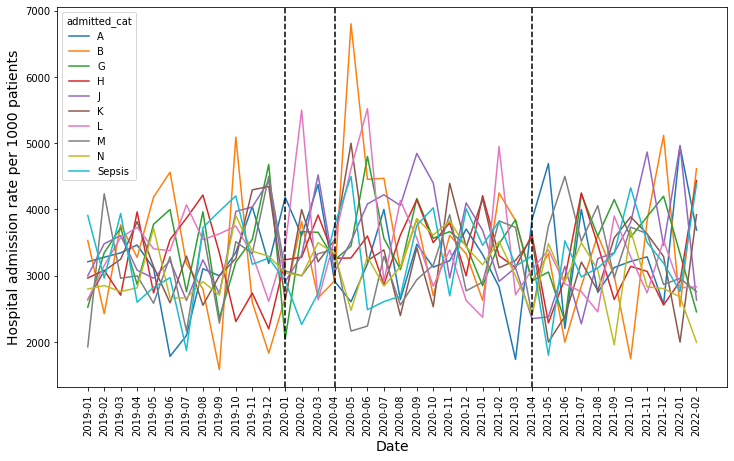

In [77]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_groupby_date, y="value_mean", x="date", hue="admitted_cat", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.locator_params(axis='x', nbins=5)
# plt.(np.arange(min(data_hosp_rate_cat_sex_age_cat_groupby_date.date), max(data_hosp_rate_cat_sex_age_cat_groupby_date.date))+1, 1.0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
plt.show()

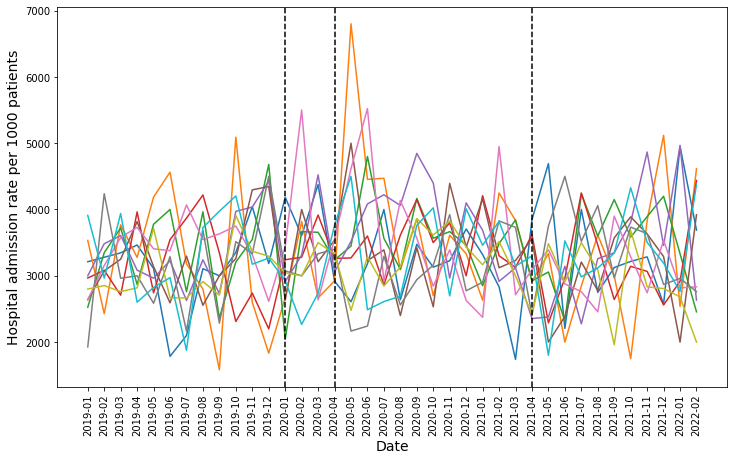

In [78]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_groupby_date, y="value_mean", x="date", hue="admitted_cat", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.locator_params(axis='x', nbins=5)
# plt.(np.arange(min(data_hosp_rate_cat_sex_age_cat_groupby_date.date), max(data_hosp_rate_cat_sex_age_cat_groupby_date.date))+1, 1.0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission rate with GP consultation

In [79]:
data_hosp_rate_gp

,gp_cons_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,0,0,1421.0,451,3.150776,2019-01-01
2,1,0,1332.0,449,2.966592,2019-01-01
4,0,0,1525.0,457,3.336980,2019-02-01
6,1,0,1530.0,443,3.453725,2019-02-01
8,0,0,1584.0,448,3.535714,2019-03-01
...,...,...,...,...,...,...
142,1,0,1602.0,452,3.544248,2021-12-01
144,0,0,1444.0,438,3.296804,2022-01-01
146,1,0,1583.0,462,3.426407,2022-01-01
148,0,0,1500.0,441,3.401361,2022-02-01


In [80]:
data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].mean()#sum()
data_hosp_rate_gp_groupby_date

,date,gp_cons_admitted_binary,value
0,2019-01-01,0,3.150776
1,2019-01-01,1,2.966592
2,2019-02-01,0,3.336980
3,2019-02-01,1,3.453725
4,2019-03-01,0,3.535714
...,...,...,...
71,2021-12-01,1,3.544248
72,2022-01-01,0,3.296804
73,2022-01-01,1,3.426407
74,2022-02-01,0,3.401361


In [81]:
# data_hosp_rate_sex_age_cat_gp.groupby([data_hosp_rate_sex_age_cat['date']]).sum()

In [82]:
# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_gp.groupby(['date', 'gp_cons_admitted_binary']).agg({'value': ['mean', 'min', 'max', 'sum']})
# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp_groupby_date.reset_index()
# data_hosp_rate_sex_age_cat_gp_groupby_date.columns = ['date', 'gp_cons_admitted_binary', 'value_mean', 'value_min', 'value_max', 'value_sum']
# data_hosp_rate_sex_age_cat_gp_groupby_date

In [83]:
data_hosp_rate_gp_groupby_date.date = pd.to_datetime(data_hosp_rate_gp_groupby_date.date)

data_hosp_rate_gp_groupby_date.date = data_hosp_rate_gp_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_gp_groupby_date.head()

,date,gp_cons_admitted_binary,value
0,2019-01,0,3.150776
1,2019-01,1,2.966592
2,2019-02,0,3.336980
3,2019-02,1,3.453725
4,2019-03,0,3.535714


In [84]:
data_hosp_rate_gp_groupby_date['value'] = data_hosp_rate_gp_groupby_date['value']*1000

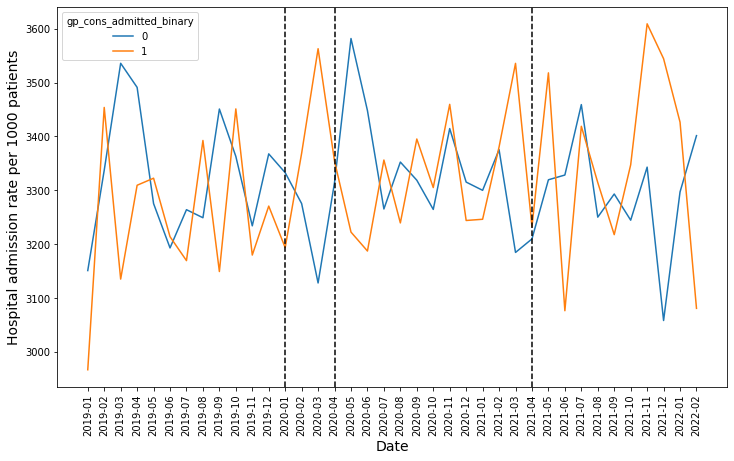

In [85]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", ax=ax1)

plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient.jpg')
plt.show()

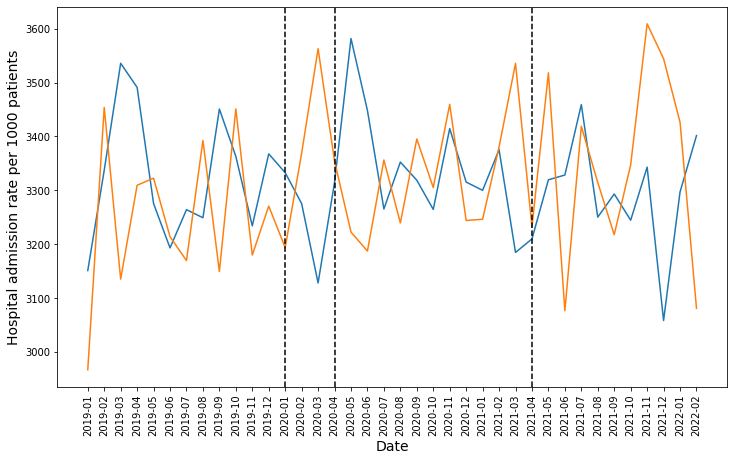

In [86]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", ax=ax1)

plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_nolegend.jpg')
plt.show()